In [7]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [31]:
# 定义输入尺寸和超参数
IMG_SIZE = 48
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 200
LEARNING_RATE = 0.001

# 数据文件夹路径
train_dir = "./Training"
validation_dir = "./PublicTest"

In [32]:
# 定义数据增强和预处理
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),           # 随机水平翻转
    transforms.RandomRotation(10),              # 随机旋转
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移
    transforms.ToTensor(),                      # 转换为张量
    transforms.Normalize(mean=[0.485], std=[0.229]) # 使用预训练好的 ResNet 模型时，均值和标准差通常是根据预训练所使用的数据集（例如 ImageNet）预先计算好的。
])

validation_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# 创建数据集
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
validation_dataset = ImageFolder(root=validation_dir, transform=validation_transforms)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 检查数据集是否正确加载
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")

Number of training samples: 25337
Number of validation samples: 3589


In [33]:
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cpu()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        log_probs = torch.nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# 构建ResNet-18

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 
 
class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
 
        self.shortcut = nn.Sequential()
 
        '''
        如果步长 stride 不为 1 或者输入通道数 in_planes 不等于扩展系数 self.expansion 乘以输出通道数 planes，
        则需要进行维度匹配，使用一个包含一个卷积层和一个批量归一化层的序列 self.shortcut 来进行匹配
        '''
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
 
 
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
 
 
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 64
 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, NUM_CLASSES)
 
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
 
 
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# 开始训练

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)  # 余弦退火学习率调度器

# 使用标签平滑系数0.1
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)  

# train model
num_epochs = EPOCHS
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
all_labels = []
all_predictions = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用 tqdm 显示训练进度
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Step 1: 应用MixUp
        mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.2)

        # Step 2: 前向传播
        outputs = model(mixed_inputs)

        # Step 3: 计算混合损失（已包含标签平滑）
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        # Step 4: 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # 调整学习率
    scheduler.step()

    # 评估模型
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print('Finished Training')

# 保存模型
torch.save(model, 'ResNet18_mixup.pt')

Epoch 1/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 1, Train Loss: 1.7340, Train Accuracy: 27.17%
Epoch 1, Val Loss: 1.9113, Val Accuracy: 29.95%


Epoch 2/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 2, Train Loss: 1.6567, Train Accuracy: 30.97%
Epoch 2, Val Loss: 1.8650, Val Accuracy: 34.19%


Epoch 3/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 3, Train Loss: 1.5749, Train Accuracy: 33.01%
Epoch 3, Val Loss: 1.8018, Val Accuracy: 39.93%


Epoch 4/200: 100%|██████████| 396/396 [00:37<00:00, 10.52it/s]


Epoch 4, Train Loss: 1.5153, Train Accuracy: 34.18%
Epoch 4, Val Loss: 1.7102, Val Accuracy: 43.91%


Epoch 5/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 5, Train Loss: 1.4827, Train Accuracy: 36.67%
Epoch 5, Val Loss: 1.6706, Val Accuracy: 45.00%


Epoch 6/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 6, Train Loss: 1.4502, Train Accuracy: 38.20%
Epoch 6, Val Loss: 1.6318, Val Accuracy: 46.84%


Epoch 7/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 7, Train Loss: 1.4215, Train Accuracy: 39.35%
Epoch 7, Val Loss: 1.6225, Val Accuracy: 47.87%


Epoch 8/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 8, Train Loss: 1.3941, Train Accuracy: 40.40%
Epoch 8, Val Loss: 1.5998, Val Accuracy: 47.31%


Epoch 9/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 9, Train Loss: 1.3999, Train Accuracy: 40.27%
Epoch 9, Val Loss: 1.5531, Val Accuracy: 50.01%


Epoch 10/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 10, Train Loss: 1.3682, Train Accuracy: 40.71%
Epoch 10, Val Loss: 1.5333, Val Accuracy: 49.74%


Epoch 11/200: 100%|██████████| 396/396 [00:37<00:00, 10.63it/s]


Epoch 11, Train Loss: 1.3597, Train Accuracy: 41.77%
Epoch 11, Val Loss: 1.5329, Val Accuracy: 50.07%


Epoch 12/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 12, Train Loss: 1.3498, Train Accuracy: 41.52%
Epoch 12, Val Loss: 1.4864, Val Accuracy: 52.05%


Epoch 13/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 13, Train Loss: 1.3397, Train Accuracy: 40.37%
Epoch 13, Val Loss: 1.4671, Val Accuracy: 51.96%


Epoch 14/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 14, Train Loss: 1.3237, Train Accuracy: 42.33%
Epoch 14, Val Loss: 1.4816, Val Accuracy: 53.22%


Epoch 15/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 15, Train Loss: 1.3205, Train Accuracy: 43.17%
Epoch 15, Val Loss: 1.4900, Val Accuracy: 51.91%


Epoch 16/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 16, Train Loss: 1.3088, Train Accuracy: 40.90%
Epoch 16, Val Loss: 1.4519, Val Accuracy: 53.16%


Epoch 17/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 17, Train Loss: 1.3045, Train Accuracy: 41.75%
Epoch 17, Val Loss: 1.4491, Val Accuracy: 53.69%


Epoch 18/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 18, Train Loss: 1.2940, Train Accuracy: 41.30%
Epoch 18, Val Loss: 1.3961, Val Accuracy: 54.00%


Epoch 19/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 19, Train Loss: 1.2932, Train Accuracy: 43.19%
Epoch 19, Val Loss: 1.4268, Val Accuracy: 53.44%


Epoch 20/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 20, Train Loss: 1.2854, Train Accuracy: 43.74%
Epoch 20, Val Loss: 1.4061, Val Accuracy: 54.69%


Epoch 21/200: 100%|██████████| 396/396 [00:37<00:00, 10.64it/s]


Epoch 21, Train Loss: 1.2780, Train Accuracy: 44.32%
Epoch 21, Val Loss: 1.4255, Val Accuracy: 53.83%


Epoch 22/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 22, Train Loss: 1.2596, Train Accuracy: 43.19%
Epoch 22, Val Loss: 1.3909, Val Accuracy: 55.89%


Epoch 23/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 23, Train Loss: 1.2551, Train Accuracy: 42.44%
Epoch 23, Val Loss: 1.4040, Val Accuracy: 55.22%


Epoch 24/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 24, Train Loss: 1.2556, Train Accuracy: 44.78%
Epoch 24, Val Loss: 1.3826, Val Accuracy: 55.36%


Epoch 25/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 25, Train Loss: 1.2426, Train Accuracy: 42.83%
Epoch 25, Val Loss: 1.3799, Val Accuracy: 55.14%


Epoch 26/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 26, Train Loss: 1.2480, Train Accuracy: 42.58%
Epoch 26, Val Loss: 1.3974, Val Accuracy: 54.22%


Epoch 27/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 27, Train Loss: 1.2260, Train Accuracy: 44.37%
Epoch 27, Val Loss: 1.4141, Val Accuracy: 54.50%


Epoch 28/200: 100%|██████████| 396/396 [00:37<00:00, 10.63it/s]


Epoch 28, Train Loss: 1.2286, Train Accuracy: 44.27%
Epoch 28, Val Loss: 1.3705, Val Accuracy: 57.06%


Epoch 29/200: 100%|██████████| 396/396 [00:37<00:00, 10.64it/s]


Epoch 29, Train Loss: 1.2018, Train Accuracy: 43.69%
Epoch 29, Val Loss: 1.3714, Val Accuracy: 56.45%


Epoch 30/200: 100%|██████████| 396/396 [00:37<00:00, 10.66it/s]


Epoch 30, Train Loss: 1.2068, Train Accuracy: 45.77%
Epoch 30, Val Loss: 1.3600, Val Accuracy: 57.34%


Epoch 31/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 31, Train Loss: 1.1936, Train Accuracy: 47.06%
Epoch 31, Val Loss: 1.3355, Val Accuracy: 57.90%


Epoch 32/200: 100%|██████████| 396/396 [00:37<00:00, 10.63it/s]


Epoch 32, Train Loss: 1.2111, Train Accuracy: 45.06%
Epoch 32, Val Loss: 1.3224, Val Accuracy: 58.15%


Epoch 33/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 33, Train Loss: 1.1988, Train Accuracy: 47.08%
Epoch 33, Val Loss: 1.3179, Val Accuracy: 57.65%


Epoch 34/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 34, Train Loss: 1.1826, Train Accuracy: 46.22%
Epoch 34, Val Loss: 1.3146, Val Accuracy: 59.18%


Epoch 35/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 35, Train Loss: 1.1989, Train Accuracy: 44.54%
Epoch 35, Val Loss: 1.3655, Val Accuracy: 57.15%


Epoch 36/200: 100%|██████████| 396/396 [00:37<00:00, 10.64it/s]


Epoch 36, Train Loss: 1.1724, Train Accuracy: 45.69%
Epoch 36, Val Loss: 1.3850, Val Accuracy: 57.23%


Epoch 37/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 37, Train Loss: 1.1654, Train Accuracy: 46.68%
Epoch 37, Val Loss: 1.3423, Val Accuracy: 59.35%


Epoch 38/200: 100%|██████████| 396/396 [00:37<00:00, 10.64it/s]


Epoch 38, Train Loss: 1.1537, Train Accuracy: 47.68%
Epoch 38, Val Loss: 1.3683, Val Accuracy: 55.34%


Epoch 39/200: 100%|██████████| 396/396 [00:37<00:00, 10.66it/s]


Epoch 39, Train Loss: 1.1410, Train Accuracy: 46.87%
Epoch 39, Val Loss: 1.3863, Val Accuracy: 56.53%


Epoch 40/200: 100%|██████████| 396/396 [00:37<00:00, 10.64it/s]


Epoch 40, Train Loss: 1.1487, Train Accuracy: 45.07%
Epoch 40, Val Loss: 1.3698, Val Accuracy: 57.40%


Epoch 41/200: 100%|██████████| 396/396 [00:37<00:00, 10.64it/s]


Epoch 41, Train Loss: 1.1510, Train Accuracy: 46.29%
Epoch 41, Val Loss: 1.3342, Val Accuracy: 58.87%


Epoch 42/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 42, Train Loss: 1.1518, Train Accuracy: 45.48%
Epoch 42, Val Loss: 1.2687, Val Accuracy: 60.74%


Epoch 43/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 43, Train Loss: 1.1423, Train Accuracy: 46.36%
Epoch 43, Val Loss: 1.2746, Val Accuracy: 61.55%


Epoch 44/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 44, Train Loss: 1.1402, Train Accuracy: 45.19%
Epoch 44, Val Loss: 1.3165, Val Accuracy: 60.13%


Epoch 45/200: 100%|██████████| 396/396 [00:37<00:00, 10.66it/s]


Epoch 45, Train Loss: 1.1493, Train Accuracy: 48.82%
Epoch 45, Val Loss: 1.3872, Val Accuracy: 57.79%


Epoch 46/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 46, Train Loss: 1.1169, Train Accuracy: 47.72%
Epoch 46, Val Loss: 1.3150, Val Accuracy: 59.99%


Epoch 47/200: 100%|██████████| 396/396 [00:37<00:00, 10.66it/s]


Epoch 47, Train Loss: 1.1279, Train Accuracy: 47.49%
Epoch 47, Val Loss: 1.3482, Val Accuracy: 58.76%


Epoch 48/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 48, Train Loss: 1.1338, Train Accuracy: 49.84%
Epoch 48, Val Loss: 1.3287, Val Accuracy: 59.24%


Epoch 49/200: 100%|██████████| 396/396 [00:37<00:00, 10.63it/s]


Epoch 49, Train Loss: 1.1171, Train Accuracy: 47.12%
Epoch 49, Val Loss: 1.3540, Val Accuracy: 58.48%


Epoch 50/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 50, Train Loss: 1.1405, Train Accuracy: 47.39%
Epoch 50, Val Loss: 1.3102, Val Accuracy: 60.10%


Epoch 51/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 51, Train Loss: 1.0860, Train Accuracy: 46.99%
Epoch 51, Val Loss: 1.3067, Val Accuracy: 60.80%


Epoch 52/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 52, Train Loss: 1.0842, Train Accuracy: 45.77%
Epoch 52, Val Loss: 1.3439, Val Accuracy: 60.16%


Epoch 53/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 53, Train Loss: 1.1059, Train Accuracy: 50.03%
Epoch 53, Val Loss: 1.3235, Val Accuracy: 60.10%


Epoch 54/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 54, Train Loss: 1.0927, Train Accuracy: 46.24%
Epoch 54, Val Loss: 1.2960, Val Accuracy: 61.08%


Epoch 55/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 55, Train Loss: 1.0770, Train Accuracy: 48.37%
Epoch 55, Val Loss: 1.3271, Val Accuracy: 60.10%


Epoch 56/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 56, Train Loss: 1.0801, Train Accuracy: 47.26%
Epoch 56, Val Loss: 1.3477, Val Accuracy: 59.68%


Epoch 57/200: 100%|██████████| 396/396 [00:37<00:00, 10.66it/s]


Epoch 57, Train Loss: 1.0667, Train Accuracy: 51.13%
Epoch 57, Val Loss: 1.3110, Val Accuracy: 60.52%


Epoch 58/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 58, Train Loss: 1.0525, Train Accuracy: 50.85%
Epoch 58, Val Loss: 1.2738, Val Accuracy: 62.47%


Epoch 59/200: 100%|██████████| 396/396 [00:37<00:00, 10.63it/s]


Epoch 59, Train Loss: 1.0649, Train Accuracy: 48.51%
Epoch 59, Val Loss: 1.3519, Val Accuracy: 61.02%


Epoch 60/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 60, Train Loss: 1.0516, Train Accuracy: 48.54%
Epoch 60, Val Loss: 1.3266, Val Accuracy: 60.94%


Epoch 61/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 61, Train Loss: 1.0315, Train Accuracy: 50.99%
Epoch 61, Val Loss: 1.3372, Val Accuracy: 60.43%


Epoch 62/200: 100%|██████████| 396/396 [00:37<00:00, 10.52it/s]


Epoch 62, Train Loss: 1.0549, Train Accuracy: 48.91%
Epoch 62, Val Loss: 1.3672, Val Accuracy: 59.32%


Epoch 63/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 63, Train Loss: 1.0194, Train Accuracy: 46.54%
Epoch 63, Val Loss: 1.3096, Val Accuracy: 61.21%


Epoch 64/200: 100%|██████████| 396/396 [00:37<00:00, 10.64it/s]


Epoch 64, Train Loss: 1.0339, Train Accuracy: 49.31%
Epoch 64, Val Loss: 1.4079, Val Accuracy: 57.51%


Epoch 65/200: 100%|██████████| 396/396 [00:37<00:00, 10.66it/s]


Epoch 65, Train Loss: 1.0324, Train Accuracy: 50.55%
Epoch 65, Val Loss: 1.4007, Val Accuracy: 59.38%


Epoch 66/200: 100%|██████████| 396/396 [00:37<00:00, 10.66it/s]


Epoch 66, Train Loss: 1.0187, Train Accuracy: 51.02%
Epoch 66, Val Loss: 1.3479, Val Accuracy: 61.30%


Epoch 67/200: 100%|██████████| 396/396 [00:37<00:00, 10.64it/s]


Epoch 67, Train Loss: 1.0071, Train Accuracy: 51.52%
Epoch 67, Val Loss: 1.2908, Val Accuracy: 62.75%


Epoch 68/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 68, Train Loss: 1.0216, Train Accuracy: 52.54%
Epoch 68, Val Loss: 1.3804, Val Accuracy: 60.52%


Epoch 69/200: 100%|██████████| 396/396 [00:37<00:00, 10.63it/s]


Epoch 69, Train Loss: 1.0332, Train Accuracy: 50.28%
Epoch 69, Val Loss: 1.3311, Val Accuracy: 59.79%


Epoch 70/200: 100%|██████████| 396/396 [00:37<00:00, 10.63it/s]


Epoch 70, Train Loss: 1.0067, Train Accuracy: 51.62%
Epoch 70, Val Loss: 1.3206, Val Accuracy: 62.30%


Epoch 71/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 71, Train Loss: 1.0028, Train Accuracy: 52.13%
Epoch 71, Val Loss: 1.3157, Val Accuracy: 61.77%


Epoch 72/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 72, Train Loss: 0.9934, Train Accuracy: 53.81%
Epoch 72, Val Loss: 1.3250, Val Accuracy: 62.08%


Epoch 73/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 73, Train Loss: 0.9667, Train Accuracy: 51.33%
Epoch 73, Val Loss: 1.3370, Val Accuracy: 62.19%


Epoch 74/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 74, Train Loss: 0.9784, Train Accuracy: 52.17%
Epoch 74, Val Loss: 1.3246, Val Accuracy: 61.35%


Epoch 75/200: 100%|██████████| 396/396 [00:37<00:00, 10.65it/s]


Epoch 75, Train Loss: 0.9779, Train Accuracy: 48.42%
Epoch 75, Val Loss: 1.3347, Val Accuracy: 61.88%


Epoch 76/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 76, Train Loss: 0.9925, Train Accuracy: 51.58%
Epoch 76, Val Loss: 1.3333, Val Accuracy: 60.55%


Epoch 77/200: 100%|██████████| 396/396 [00:37<00:00, 10.45it/s]


Epoch 77, Train Loss: 0.9585, Train Accuracy: 54.85%
Epoch 77, Val Loss: 1.3782, Val Accuracy: 60.69%


Epoch 78/200: 100%|██████████| 396/396 [00:38<00:00, 10.36it/s]


Epoch 78, Train Loss: 0.9675, Train Accuracy: 51.62%
Epoch 78, Val Loss: 1.3898, Val Accuracy: 60.16%


Epoch 79/200: 100%|██████████| 396/396 [00:37<00:00, 10.44it/s]


Epoch 79, Train Loss: 0.9537, Train Accuracy: 54.26%
Epoch 79, Val Loss: 1.3206, Val Accuracy: 62.97%


Epoch 80/200: 100%|██████████| 396/396 [00:37<00:00, 10.43it/s]


Epoch 80, Train Loss: 0.9697, Train Accuracy: 51.66%
Epoch 80, Val Loss: 1.3536, Val Accuracy: 61.94%


Epoch 81/200: 100%|██████████| 396/396 [00:37<00:00, 10.52it/s]


Epoch 81, Train Loss: 0.9632, Train Accuracy: 50.94%
Epoch 81, Val Loss: 1.3310, Val Accuracy: 61.02%


Epoch 82/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 82, Train Loss: 0.9612, Train Accuracy: 51.91%
Epoch 82, Val Loss: 1.3760, Val Accuracy: 61.99%


Epoch 83/200: 100%|██████████| 396/396 [00:37<00:00, 10.51it/s]


Epoch 83, Train Loss: 0.9353, Train Accuracy: 52.84%
Epoch 83, Val Loss: 1.4213, Val Accuracy: 60.91%


Epoch 84/200: 100%|██████████| 396/396 [00:37<00:00, 10.48it/s]


Epoch 84, Train Loss: 0.9271, Train Accuracy: 49.39%
Epoch 84, Val Loss: 1.3687, Val Accuracy: 62.19%


Epoch 85/200: 100%|██████████| 396/396 [00:37<00:00, 10.50it/s]


Epoch 85, Train Loss: 0.9526, Train Accuracy: 53.44%
Epoch 85, Val Loss: 1.3434, Val Accuracy: 62.19%


Epoch 86/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 86, Train Loss: 0.9341, Train Accuracy: 52.65%
Epoch 86, Val Loss: 1.3599, Val Accuracy: 60.85%


Epoch 87/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 87, Train Loss: 0.9297, Train Accuracy: 53.46%
Epoch 87, Val Loss: 1.3695, Val Accuracy: 60.74%


Epoch 88/200: 100%|██████████| 396/396 [00:37<00:00, 10.53it/s]


Epoch 88, Train Loss: 0.9178, Train Accuracy: 53.67%
Epoch 88, Val Loss: 1.3845, Val Accuracy: 60.27%


Epoch 89/200: 100%|██████████| 396/396 [00:37<00:00, 10.53it/s]


Epoch 89, Train Loss: 0.9378, Train Accuracy: 51.22%
Epoch 89, Val Loss: 1.3194, Val Accuracy: 62.94%


Epoch 90/200: 100%|██████████| 396/396 [00:38<00:00, 10.20it/s]


Epoch 90, Train Loss: 0.9228, Train Accuracy: 56.97%
Epoch 90, Val Loss: 1.3570, Val Accuracy: 62.69%


Epoch 91/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 91, Train Loss: 0.8876, Train Accuracy: 53.28%
Epoch 91, Val Loss: 1.3799, Val Accuracy: 63.08%


Epoch 92/200: 100%|██████████| 396/396 [00:37<00:00, 10.53it/s]


Epoch 92, Train Loss: 0.9351, Train Accuracy: 53.23%
Epoch 92, Val Loss: 1.3616, Val Accuracy: 61.35%


Epoch 93/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 93, Train Loss: 0.9069, Train Accuracy: 56.66%
Epoch 93, Val Loss: 1.3613, Val Accuracy: 61.99%


Epoch 94/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 94, Train Loss: 0.8942, Train Accuracy: 53.76%
Epoch 94, Val Loss: 1.3308, Val Accuracy: 63.19%


Epoch 95/200: 100%|██████████| 396/396 [00:38<00:00, 10.40it/s]


Epoch 95, Train Loss: 0.8913, Train Accuracy: 54.15%
Epoch 95, Val Loss: 1.4082, Val Accuracy: 61.52%


Epoch 96/200: 100%|██████████| 396/396 [00:38<00:00, 10.42it/s]


Epoch 96, Train Loss: 0.9062, Train Accuracy: 54.74%
Epoch 96, Val Loss: 1.4158, Val Accuracy: 61.13%


Epoch 97/200: 100%|██████████| 396/396 [00:37<00:00, 10.54it/s]


Epoch 97, Train Loss: 0.9003, Train Accuracy: 51.88%
Epoch 97, Val Loss: 1.3220, Val Accuracy: 63.25%


Epoch 98/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 98, Train Loss: 0.8813, Train Accuracy: 55.20%
Epoch 98, Val Loss: 1.3135, Val Accuracy: 63.58%


Epoch 99/200: 100%|██████████| 396/396 [00:37<00:00, 10.56it/s]


Epoch 99, Train Loss: 0.8881, Train Accuracy: 50.83%
Epoch 99, Val Loss: 1.3613, Val Accuracy: 63.50%


Epoch 100/200: 100%|██████████| 396/396 [00:37<00:00, 10.51it/s]


Epoch 100, Train Loss: 0.8801, Train Accuracy: 55.80%
Epoch 100, Val Loss: 1.3749, Val Accuracy: 62.05%


Epoch 101/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 101, Train Loss: 0.8633, Train Accuracy: 52.50%
Epoch 101, Val Loss: 1.3594, Val Accuracy: 61.94%


Epoch 102/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 102, Train Loss: 0.8684, Train Accuracy: 53.59%
Epoch 102, Val Loss: 1.3925, Val Accuracy: 63.08%


Epoch 103/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 103, Train Loss: 0.8628, Train Accuracy: 54.04%
Epoch 103, Val Loss: 1.3804, Val Accuracy: 62.64%


Epoch 104/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 104, Train Loss: 0.8981, Train Accuracy: 49.43%
Epoch 104, Val Loss: 1.3594, Val Accuracy: 63.00%


Epoch 105/200: 100%|██████████| 396/396 [00:37<00:00, 10.51it/s]


Epoch 105, Train Loss: 0.8835, Train Accuracy: 58.58%
Epoch 105, Val Loss: 1.3357, Val Accuracy: 63.05%


Epoch 106/200: 100%|██████████| 396/396 [00:37<00:00, 10.51it/s]


Epoch 106, Train Loss: 0.8567, Train Accuracy: 54.30%
Epoch 106, Val Loss: 1.3381, Val Accuracy: 62.75%


Epoch 107/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 107, Train Loss: 0.8406, Train Accuracy: 53.66%
Epoch 107, Val Loss: 1.3861, Val Accuracy: 61.38%


Epoch 108/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 108, Train Loss: 0.8576, Train Accuracy: 54.67%
Epoch 108, Val Loss: 1.3438, Val Accuracy: 62.64%


Epoch 109/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 109, Train Loss: 0.8714, Train Accuracy: 56.17%
Epoch 109, Val Loss: 1.3666, Val Accuracy: 63.28%


Epoch 110/200: 100%|██████████| 396/396 [00:38<00:00, 10.42it/s]


Epoch 110, Train Loss: 0.8587, Train Accuracy: 54.73%
Epoch 110, Val Loss: 1.3557, Val Accuracy: 62.16%


Epoch 111/200: 100%|██████████| 396/396 [00:37<00:00, 10.45it/s]


Epoch 111, Train Loss: 0.8428, Train Accuracy: 53.87%
Epoch 111, Val Loss: 1.3410, Val Accuracy: 62.97%


Epoch 112/200: 100%|██████████| 396/396 [00:37<00:00, 10.51it/s]


Epoch 112, Train Loss: 0.8468, Train Accuracy: 54.41%
Epoch 112, Val Loss: 1.3359, Val Accuracy: 62.89%


Epoch 113/200: 100%|██████████| 396/396 [00:37<00:00, 10.51it/s]


Epoch 113, Train Loss: 0.8891, Train Accuracy: 54.64%
Epoch 113, Val Loss: 1.3954, Val Accuracy: 62.64%


Epoch 114/200: 100%|██████████| 396/396 [00:37<00:00, 10.42it/s]


Epoch 114, Train Loss: 0.8250, Train Accuracy: 59.20%
Epoch 114, Val Loss: 1.4093, Val Accuracy: 62.75%


Epoch 115/200: 100%|██████████| 396/396 [00:37<00:00, 10.51it/s]


Epoch 115, Train Loss: 0.8313, Train Accuracy: 57.01%
Epoch 115, Val Loss: 1.3626, Val Accuracy: 63.64%


Epoch 116/200: 100%|██████████| 396/396 [00:37<00:00, 10.47it/s]


Epoch 116, Train Loss: 0.8280, Train Accuracy: 54.11%
Epoch 116, Val Loss: 1.3639, Val Accuracy: 62.08%


Epoch 117/200: 100%|██████████| 396/396 [00:37<00:00, 10.49it/s]


Epoch 117, Train Loss: 0.8383, Train Accuracy: 54.13%
Epoch 117, Val Loss: 1.3601, Val Accuracy: 63.22%


Epoch 118/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 118, Train Loss: 0.8290, Train Accuracy: 54.77%
Epoch 118, Val Loss: 1.3265, Val Accuracy: 63.53%


Epoch 119/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 119, Train Loss: 0.8510, Train Accuracy: 57.71%
Epoch 119, Val Loss: 1.3178, Val Accuracy: 64.70%


Epoch 120/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 120, Train Loss: 0.8359, Train Accuracy: 56.95%
Epoch 120, Val Loss: 1.3339, Val Accuracy: 62.58%


Epoch 121/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 121, Train Loss: 0.8217, Train Accuracy: 55.69%
Epoch 121, Val Loss: 1.3463, Val Accuracy: 63.53%


Epoch 122/200: 100%|██████████| 396/396 [00:37<00:00, 10.54it/s]


Epoch 122, Train Loss: 0.8186, Train Accuracy: 56.66%
Epoch 122, Val Loss: 1.3626, Val Accuracy: 62.94%


Epoch 123/200: 100%|██████████| 396/396 [00:37<00:00, 10.56it/s]


Epoch 123, Train Loss: 0.8118, Train Accuracy: 55.07%
Epoch 123, Val Loss: 1.3153, Val Accuracy: 63.95%


Epoch 124/200: 100%|██████████| 396/396 [00:37<00:00, 10.51it/s]


Epoch 124, Train Loss: 0.8287, Train Accuracy: 53.44%
Epoch 124, Val Loss: 1.3422, Val Accuracy: 63.89%


Epoch 125/200: 100%|██████████| 396/396 [00:38<00:00, 10.37it/s]


Epoch 125, Train Loss: 0.8027, Train Accuracy: 54.70%
Epoch 125, Val Loss: 1.3471, Val Accuracy: 62.50%


Epoch 126/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 126, Train Loss: 0.8154, Train Accuracy: 54.24%
Epoch 126, Val Loss: 1.2968, Val Accuracy: 63.83%


Epoch 127/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 127, Train Loss: 0.8150, Train Accuracy: 57.38%
Epoch 127, Val Loss: 1.3343, Val Accuracy: 63.83%


Epoch 128/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 128, Train Loss: 0.8145, Train Accuracy: 56.31%
Epoch 128, Val Loss: 1.3288, Val Accuracy: 62.83%


Epoch 129/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 129, Train Loss: 0.8118, Train Accuracy: 53.94%
Epoch 129, Val Loss: 1.3336, Val Accuracy: 64.11%


Epoch 130/200: 100%|██████████| 396/396 [00:37<00:00, 10.50it/s]


Epoch 130, Train Loss: 0.7871, Train Accuracy: 57.82%
Epoch 130, Val Loss: 1.3541, Val Accuracy: 64.06%


Epoch 131/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 131, Train Loss: 0.7899, Train Accuracy: 58.73%
Epoch 131, Val Loss: 1.3978, Val Accuracy: 63.44%


Epoch 132/200: 100%|██████████| 396/396 [00:37<00:00, 10.49it/s]


Epoch 132, Train Loss: 0.7910, Train Accuracy: 57.28%
Epoch 132, Val Loss: 1.3907, Val Accuracy: 62.80%


Epoch 133/200: 100%|██████████| 396/396 [00:37<00:00, 10.50it/s]


Epoch 133, Train Loss: 0.7911, Train Accuracy: 60.05%
Epoch 133, Val Loss: 1.3327, Val Accuracy: 63.86%


Epoch 134/200: 100%|██████████| 396/396 [00:37<00:00, 10.49it/s]


Epoch 134, Train Loss: 0.7983, Train Accuracy: 54.25%
Epoch 134, Val Loss: 1.3205, Val Accuracy: 63.33%


Epoch 135/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 135, Train Loss: 0.8183, Train Accuracy: 56.39%
Epoch 135, Val Loss: 1.3602, Val Accuracy: 63.47%


Epoch 136/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 136, Train Loss: 0.7997, Train Accuracy: 56.44%
Epoch 136, Val Loss: 1.3517, Val Accuracy: 63.03%


Epoch 137/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 137, Train Loss: 0.7913, Train Accuracy: 57.96%
Epoch 137, Val Loss: 1.3560, Val Accuracy: 63.08%


Epoch 138/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 138, Train Loss: 0.7932, Train Accuracy: 59.14%
Epoch 138, Val Loss: 1.3525, Val Accuracy: 63.25%


Epoch 139/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 139, Train Loss: 0.7951, Train Accuracy: 56.69%
Epoch 139, Val Loss: 1.3485, Val Accuracy: 63.42%


Epoch 140/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 140, Train Loss: 0.7906, Train Accuracy: 54.58%
Epoch 140, Val Loss: 1.3331, Val Accuracy: 63.56%


Epoch 141/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 141, Train Loss: 0.7790, Train Accuracy: 57.27%
Epoch 141, Val Loss: 1.3614, Val Accuracy: 63.14%


Epoch 142/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 142, Train Loss: 0.7544, Train Accuracy: 56.74%
Epoch 142, Val Loss: 1.3453, Val Accuracy: 63.36%


Epoch 143/200: 100%|██████████| 396/396 [00:37<00:00, 10.56it/s]


Epoch 143, Train Loss: 0.7707, Train Accuracy: 57.67%
Epoch 143, Val Loss: 1.3686, Val Accuracy: 63.56%


Epoch 144/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 144, Train Loss: 0.7781, Train Accuracy: 56.52%
Epoch 144, Val Loss: 1.3502, Val Accuracy: 64.36%


Epoch 145/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 145, Train Loss: 0.7973, Train Accuracy: 59.27%
Epoch 145, Val Loss: 1.3253, Val Accuracy: 63.08%


Epoch 146/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 146, Train Loss: 0.7936, Train Accuracy: 54.78%
Epoch 146, Val Loss: 1.3528, Val Accuracy: 62.72%


Epoch 147/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 147, Train Loss: 0.7868, Train Accuracy: 54.64%
Epoch 147, Val Loss: 1.3249, Val Accuracy: 63.42%


Epoch 148/200: 100%|██████████| 396/396 [00:37<00:00, 10.63it/s]


Epoch 148, Train Loss: 0.7904, Train Accuracy: 55.94%
Epoch 148, Val Loss: 1.3483, Val Accuracy: 63.89%


Epoch 149/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 149, Train Loss: 0.7547, Train Accuracy: 56.83%
Epoch 149, Val Loss: 1.3715, Val Accuracy: 63.25%


Epoch 150/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 150, Train Loss: 0.7856, Train Accuracy: 53.42%
Epoch 150, Val Loss: 1.3381, Val Accuracy: 63.19%


Epoch 151/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 151, Train Loss: 0.7676, Train Accuracy: 58.98%
Epoch 151, Val Loss: 1.3507, Val Accuracy: 62.33%


Epoch 152/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 152, Train Loss: 0.7723, Train Accuracy: 55.95%
Epoch 152, Val Loss: 1.3197, Val Accuracy: 64.03%


Epoch 153/200: 100%|██████████| 396/396 [00:37<00:00, 10.52it/s]


Epoch 153, Train Loss: 0.7697, Train Accuracy: 55.17%
Epoch 153, Val Loss: 1.3384, Val Accuracy: 64.22%


Epoch 154/200: 100%|██████████| 396/396 [00:37<00:00, 10.56it/s]


Epoch 154, Train Loss: 0.7747, Train Accuracy: 57.37%
Epoch 154, Val Loss: 1.3649, Val Accuracy: 62.86%


Epoch 155/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 155, Train Loss: 0.7660, Train Accuracy: 59.23%
Epoch 155, Val Loss: 1.3396, Val Accuracy: 63.58%


Epoch 156/200: 100%|██████████| 396/396 [00:37<00:00, 10.61it/s]


Epoch 156, Train Loss: 0.7898, Train Accuracy: 59.15%
Epoch 156, Val Loss: 1.3386, Val Accuracy: 63.58%


Epoch 157/200: 100%|██████████| 396/396 [00:37<00:00, 10.62it/s]


Epoch 157, Train Loss: 0.7799, Train Accuracy: 56.94%
Epoch 157, Val Loss: 1.3404, Val Accuracy: 63.47%


Epoch 158/200: 100%|██████████| 396/396 [00:37<00:00, 10.60it/s]


Epoch 158, Train Loss: 0.7782, Train Accuracy: 57.26%
Epoch 158, Val Loss: 1.3264, Val Accuracy: 63.39%


Epoch 159/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 159, Train Loss: 0.7866, Train Accuracy: 59.25%
Epoch 159, Val Loss: 1.3570, Val Accuracy: 63.95%


Epoch 160/200: 100%|██████████| 396/396 [00:37<00:00, 10.59it/s]


Epoch 160, Train Loss: 0.7971, Train Accuracy: 58.20%
Epoch 160, Val Loss: 1.3480, Val Accuracy: 63.69%


Epoch 161/200: 100%|██████████| 396/396 [00:37<00:00, 10.56it/s]


Epoch 161, Train Loss: 0.8024, Train Accuracy: 56.32%
Epoch 161, Val Loss: 1.3542, Val Accuracy: 64.11%


Epoch 162/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 162, Train Loss: 0.7489, Train Accuracy: 58.47%
Epoch 162, Val Loss: 1.3677, Val Accuracy: 63.42%


Epoch 163/200: 100%|██████████| 396/396 [00:37<00:00, 10.57it/s]


Epoch 163, Train Loss: 0.8072, Train Accuracy: 58.16%
Epoch 163, Val Loss: 1.3103, Val Accuracy: 63.05%


Epoch 164/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 164, Train Loss: 0.7709, Train Accuracy: 56.18%
Epoch 164, Val Loss: 1.3495, Val Accuracy: 62.69%


Epoch 165/200: 100%|██████████| 396/396 [00:37<00:00, 10.45it/s]


Epoch 165, Train Loss: 0.7701, Train Accuracy: 55.52%
Epoch 165, Val Loss: 1.3514, Val Accuracy: 63.42%


Epoch 166/200: 100%|██████████| 396/396 [00:37<00:00, 10.58it/s]


Epoch 166, Train Loss: 0.7895, Train Accuracy: 59.55%
Epoch 166, Val Loss: 1.3183, Val Accuracy: 63.30%


Epoch 167/200: 100%|██████████| 396/396 [00:37<00:00, 10.50it/s]


Epoch 167, Train Loss: 0.7874, Train Accuracy: 56.64%
Epoch 167, Val Loss: 1.3104, Val Accuracy: 63.50%


Epoch 168/200: 100%|██████████| 396/396 [00:37<00:00, 10.55it/s]


Epoch 168, Train Loss: 0.7546, Train Accuracy: 57.07%
Epoch 168, Val Loss: 1.3696, Val Accuracy: 63.89%


Epoch 169/200: 100%|██████████| 396/396 [00:37<00:00, 10.56it/s]


Epoch 169, Train Loss: 0.7820, Train Accuracy: 56.87%
Epoch 169, Val Loss: 1.3524, Val Accuracy: 63.97%


Epoch 170/200: 100%|██████████| 396/396 [00:37<00:00, 10.50it/s]


Epoch 170, Train Loss: 0.7549, Train Accuracy: 60.56%
Epoch 170, Val Loss: 1.3481, Val Accuracy: 63.75%


Epoch 171/200:  35%|███▌      | 140/396 [00:13<00:24, 10.40it/s]


KeyboardInterrupt: 

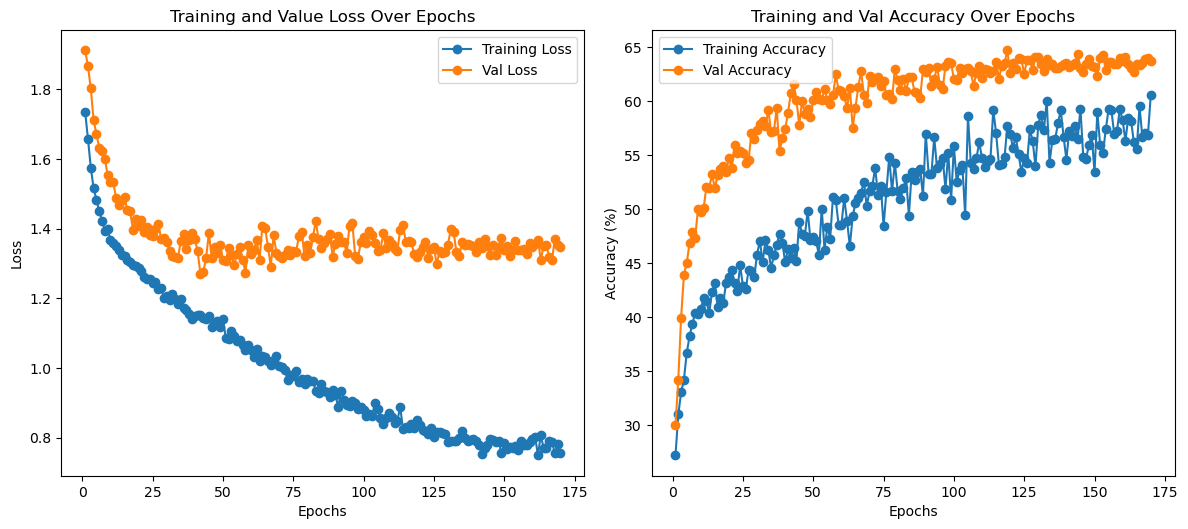

ValueError: Found input variables with inconsistent numbers of samples: [3589, 610130]

In [49]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Draw the accuracy and loss curves
epochs = range(1, 170 + 1)
plt.figure(figsize=(12, 10))

# Plotting training and val loss curves
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.plot(epochs, val_losses, 'o-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Value Loss Over Epochs')
plt.legend()

# Plot training and val accuracy curves
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'o-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'o-', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Val Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Calculating F1-score, Precision and Recall
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'F1 Score (Weighted): {f1:.4f}')

# 测试

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 确保你的设备是 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 64

test_dir = "./PrivateTest"

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),        
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

C:\Users\HE\AppData\Local\Temp\ipykernel_17560\1692390496.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("ResNet18_mixup.pt")


Test Accuracy: 64.36%
Confusion Matrix:
 [[305   8  59  17  43  59   0]
 [  9  38   3   1   1   3   0]
 [ 69   1 324  17  50  66   1]
 [ 15   0  20 797  24  22   1]
 [ 32   1  34  39 456  64   0]
 [ 63   1  82  31 105 311   1]
 [ 39   0 194  52  36  16  79]]


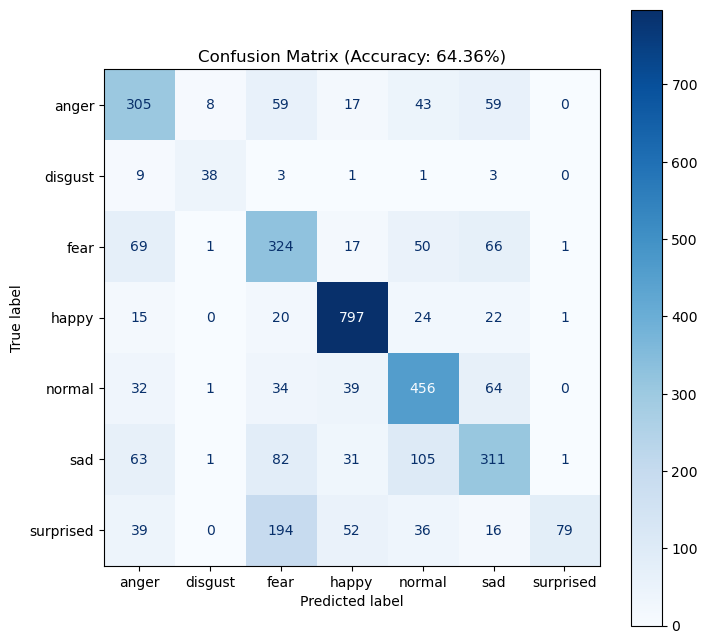

In [47]:
# 定义模型结构（与保存权重时一致）
model = torch.load("ResNet18_mixup.pt")
model = model.to(device)
model.eval()  # 切换到评估模式

# 初始化真实标签和预测标签
all_labels = []
all_preds = []

# 模型测试并记录标签
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# 绘制混淆矩阵
labels = test_dataset.classes  # 获取类别名称
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f}%)")
plt.show()

In [11]:
import torch
import numpy as np
import cv2

# 加载预训练的情感识别模型
model = torch.load("ResNet18_mixup.pt")

# 定义情感类别
emotion_dict = {0: "anger", 1: "disgust", 2: "fear", 3: "happy", 4: "normal", 5: "sad", 6: "surprised"}

# 加载人脸检测器
facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# 实时情感识别
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # 转为灰度图像
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # 检测人脸
    faces = facecasc.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    # 对检测到的每个人脸进行情感识别
    for (x, y, w, h) in faces:
        # 绘制人脸区域的矩形框
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        
        # 预处理人脸图像
        roi_gray = gray[y:y + h, x:x + w]
        resized_image = cv2.resize(roi_gray, (48, 48))
        input_image = np.expand_dims(np.expand_dims(resized_image, axis=-1), axis=0)
        input_image = input_image / 255.0  # 归一化处理

        # 情感预测
        prediction = model.predict(input_image)
        max_index = np.argmax(prediction)
        max_prob = np.max(prediction)
        
        # 设置预测阈值
        # threshold = 0.5
        # if max_prob >= threshold:
        #     predicted_emotion = emotion_dict[max_index]
        # else:
        #     predicted_emotion = "Uncertain"
        predicted_emotion = emotion_dict[max_index]
        
        # 显示预测结果
        cv2.putText(frame, predicted_emotion, (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # 显示视频流
    cv2.imshow('Real-time Emotion Recognition', cv2.resize(frame, (800, 600), interpolation=cv2.INTER_CUBIC))

    # 按 'q' 键退出
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

C:\Users\HE\AppData\Local\Temp\ipykernel_22880\3325681793.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("ResNet18_mixup.pt")


AttributeError: Can't get attribute 'ResNet' on <module '__main__'>